In [1]:
!pip install --quiet --upgrade scikit-learn imbalanced-learn shap matplotlib seaborn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold

from IPython.core.interactiveshell import InteractiveShell

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [3]:
# Show output of all expressions from a cell.
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# Show output of all expressions from a cell.
InteractiveShell.ast_node_interactivity = "all"

In [5]:
df = pd.read_csv('asthma_disease_data.csv')
df.head()
df.info()
print("Columns = ", df.columns)
print("Shape = ", df.shape)

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,...,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis,DoctorInCharge
0,5034,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,...,1.369051,4.941206,0,0,1,0,0,1,0,Dr_Confid
1,5035,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,...,2.197767,1.702393,1,0,0,1,1,1,0,Dr_Confid
2,5036,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,...,1.698011,5.022553,1,1,1,0,1,1,0,Dr_Confid
3,5037,40,1,2,1,38.515278,0,1.404503,5.826532,4.253036,...,3.032037,2.300159,1,0,1,1,1,0,0,Dr_Confid
4,5038,61,0,0,3,19.283802,0,4.604493,3.127048,9.625799,...,3.470589,3.067944,1,1,1,0,0,1,0,Dr_Confid


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               2392 non-null   int64  
 1   Age                     2392 non-null   int64  
 2   Gender                  2392 non-null   int64  
 3   Ethnicity               2392 non-null   int64  
 4   EducationLevel          2392 non-null   int64  
 5   BMI                     2392 non-null   float64
 6   Smoking                 2392 non-null   int64  
 7   PhysicalActivity        2392 non-null   float64
 8   DietQuality             2392 non-null   float64
 9   SleepQuality            2392 non-null   float64
 10  PollutionExposure       2392 non-null   float64
 11  PollenExposure          2392 non-null   float64
 12  DustExposure            2392 non-null   float64
 13  PetAllergy              2392 non-null   int64  
 14  FamilyHistoryAsthma     2392 non-null   

In [6]:
# Keep this cell commented out to run a model together for children and adults.

# Uncomment below to run for adults.
df = df[df['Age'] >= 13]

# Uncomment below to run for children.
#df = df[df['Age'] < 13]

In [7]:
def calculate_predicted_fvc(age, gender, ethnicity):
  if ethnicity == 0:    # Caucasian
        A, B, C = (0.0417, 0.0264, 0.0747) if gender == 0 else (0.0400, 0.0250, 0.0700)
  elif ethnicity == 1:  # African American
        A, B, C = (0.0390, 0.0240, 0.0650) if gender == 0 else (0.0375, 0.0230, 0.0600)
  elif ethnicity == 2:  # Asian
        A, B, C = (0.0380, 0.0230, 0.0500) if gender == 0 else (0.0360, 0.0220, 0.0450)
  elif ethnicity == 3:  # Other
        A, B, C = (0.0370, 0.0220, 0.0400) if gender == 0 else (0.0350, 0.0210, 0.0380)
  else:
        raise ValueError("Unknown ethnicity code")
  
  predicted_fvc = (age * A) - (gender * B) + C
  return predicted_fvc


# Apply the function to calculate predicted FVC
df['Predicted_FVC'] = df.apply(lambda row: calculate_predicted_fvc(row['Age'], row['Gender'], row['Ethnicity']), axis=1)

In [8]:
columns_to_remove = ["Ethnicity", "PatientID", "DoctorInCharge", "EducationLevel", "DietQuality", "SleepQuality"]
print("Removing columns: ", columns_to_remove)
df = df.drop(columns=columns_to_remove, errors='ignore')
df.head()
df.shape

Removing columns:  ['Ethnicity', 'PatientID', 'DoctorInCharge', 'EducationLevel', 'DietQuality', 'SleepQuality']


,Age,Gender,BMI,Smoking,PhysicalActivity,PollutionExposure,PollenExposure,DustExposure,PetAllergy,FamilyHistoryAsthma,...,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis,Predicted_FVC
0,63,0,15.848744,0,0.894448,7.388481,2.855578,0.974339,1,1,...,1.369051,4.941206,0,0,1,0,0,1,0,2.5220
1,26,1,22.757042,0,5.897329,1.969838,7.457665,6.584631,0,0,...,2.197767,1.702393,1,0,0,1,1,1,0,0.9590
2,57,0,18.395396,0,6.739367,1.460593,1.448189,5.445799,0,1,...,1.698011,5.022553,1,1,1,0,1,1,0,2.2160
3,40,1,38.515278,0,1.404503,0.581905,7.571845,3.965316,0,0,...,3.032037,2.300159,1,0,1,1,1,0,0,1.4630
4,61,0,19.283802,0,4.604493,0.980875,3.049807,8.260605,0,0,...,3.470589,3.067944,1,1,1,0,0,1,0,2.6184


(2134, 24)

In [9]:
df['PredictedToActualFVCRatio'] = df['Predicted_FVC'] / df['LungFunctionFVC']
df.shape
# Remove rows where the ratio is greater than 1.2
df = df[df['PredictedToActualFVCRatio'] <= 1.2]
df.shape
df = df.drop(columns=['Predicted_FVC'])

(2134, 25)

(1981, 25)

In [10]:
print("Before dropping rows that have FEV1>FVC, shape = ", df.shape)
df = df[df['LungFunctionFEV1'] <= df['LungFunctionFVC']]
print("After dropping rows that have FEV1>FVC, shape = ", df.shape)
df.head()

Before dropping rows that have FEV1>FVC, shape =  (1981, 24)
After dropping rows that have FEV1>FVC, shape =  (1588, 24)


,Age,Gender,BMI,Smoking,PhysicalActivity,PollutionExposure,PollenExposure,DustExposure,PetAllergy,FamilyHistoryAsthma,...,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis,PredictedToActualFVCRatio
0,63,0,15.848744,0,0.894448,7.388481,2.855578,0.974339,1,1,...,1.369051,4.941206,0,0,1,0,0,1,0,0.510402
2,57,0,18.395396,0,6.739367,1.460593,1.448189,5.445799,0,1,...,1.698011,5.022553,1,1,1,0,1,1,0,0.441210
5,21,0,21.812975,0,0.470044,1.711446,7.192424,6.832048,1,0,...,2.328191,5.898515,1,0,1,0,0,1,0,0.143765
7,26,0,26.048416,1,8.344096,6.939046,8.417881,2.190541,0,0,...,2.069343,4.012260,1,0,0,1,1,1,0,0.288840
8,49,1,32.676204,0,2.690256,3.180421,7.292903,8.568676,1,0,...,1.761242,5.190931,1,1,1,1,0,0,0,0.361111


In [11]:
# Create a new feature FEV1/FVC
print("ratio of fev1 to fvc for adults")
df['FEV1ToFVCRatio']= df['LungFunctionFEV1'] / df['LungFunctionFVC']
print(df.shape)

ratio of fev1 to fvc for adults
(1588, 25)


In [12]:
df.describe()

,Age,Gender,BMI,Smoking,PhysicalActivity,PollutionExposure,PollenExposure,DustExposure,PetAllergy,FamilyHistoryAsthma,...,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis,PredictedToActualFVCRatio,FEV1ToFVCRatio
count,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,...,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000
mean,45.485516,0.485516,27.342471,0.151763,5.028516,5.018524,5.115473,4.986768,0.159320,0.299118,...,4.257121,0.599496,0.493703,0.491184,0.487406,0.590680,0.598866,0.054156,0.465095,0.583846
std,19.152041,0.499948,7.154270,0.358904,2.896073,2.951029,2.889042,2.858160,0.366089,0.458016,...,1.081453,0.490155,0.500118,0.500080,0.499999,0.491863,0.490282,0.226397,0.230020,0.206195
min,13.000000,0.000000,15.031803,0.000000,0.001740,0.001022,0.000736,0.002434,0.000000,0.000000,...,1.505442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089187,0.171552
25%,29.000000,0.000000,21.102543,0.000000,2.542668,2.452321,2.646479,2.491682,0.000000,0.000000,...,3.449127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.282231,0.415104
50%,45.000000,0.000000,27.367362,0.000000,5.015494,5.000547,5.063571,4.878305,0.000000,0.000000,...,4.336078,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.435675,0.583168
75%,62.000000,1.000000,33.594906,0.000000,7.454447,7.677320,7.692808,7.472596,0.000000,1.000000,...,5.165373,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.607815,0.745147
max,79.000000,1.000000,39.985611,1.000000,9.987077,9.998964,9.999555,9.990634,1.000000,1.000000,...,5.999421,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.184534,0.997551


<Axes: xlabel='Age', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Age')

Text(0.5, 0, 'Age')

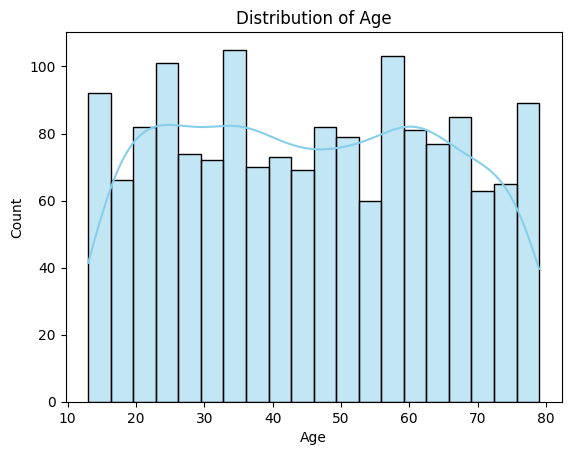

In [13]:
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')

/var/folders/58/t76sxn_93sz7kp5fv10pnltr0000gn/T/ipykernel_39625/4009089206.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df, palette='pastel')


<Axes: xlabel='Gender', ylabel='count'>

Text(0.5, 1.0, 'Count of Gender')

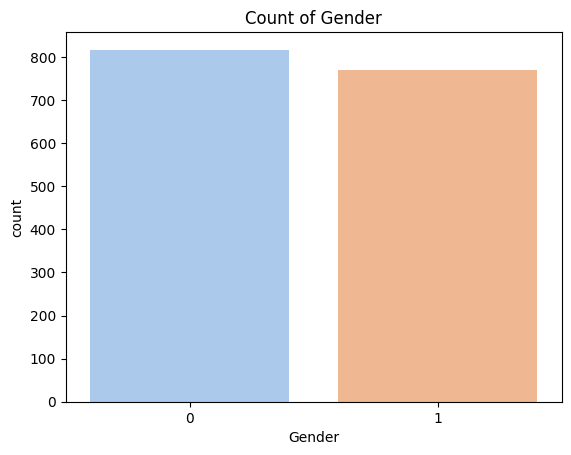

In [14]:
sns.countplot(x='Gender', data=df, palette='pastel')
plt.title('Count of Gender')

<Axes: xlabel='BMI', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of BMI')

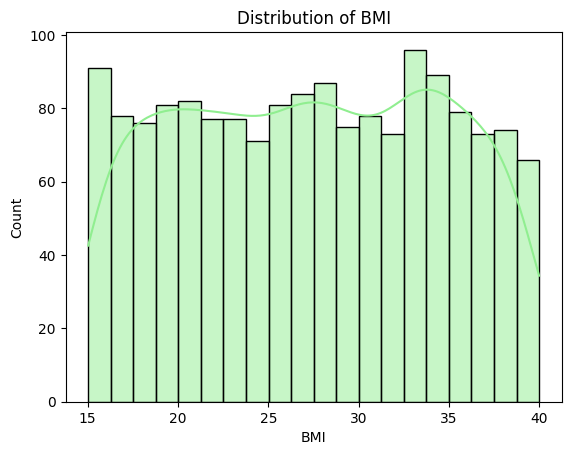

In [15]:
sns.histplot(df['BMI'], bins=20, kde=True, color='lightgreen')
plt.title('Distribution of BMI')


<Axes: xlabel='BMI', ylabel='LungFunctionFEV1'>

Text(0.5, 1.0, 'BMI vs Lung Function (FEV1)')

Text(0.5, 0, 'BMI')

Text(0, 0.5, 'FEV1')

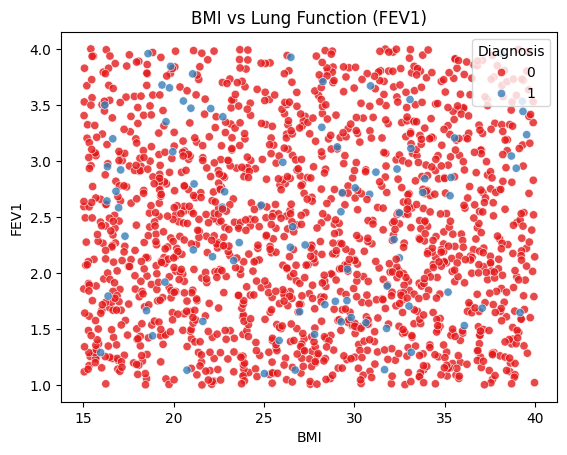

In [16]:
sns.scatterplot(x='BMI', y='LungFunctionFEV1', data=df, hue='Diagnosis', palette='Set1', alpha=0.8)
plt.title('BMI vs Lung Function (FEV1)')
plt.xlabel('BMI')
plt.ylabel('FEV1')

<Figure size 1200x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Features')

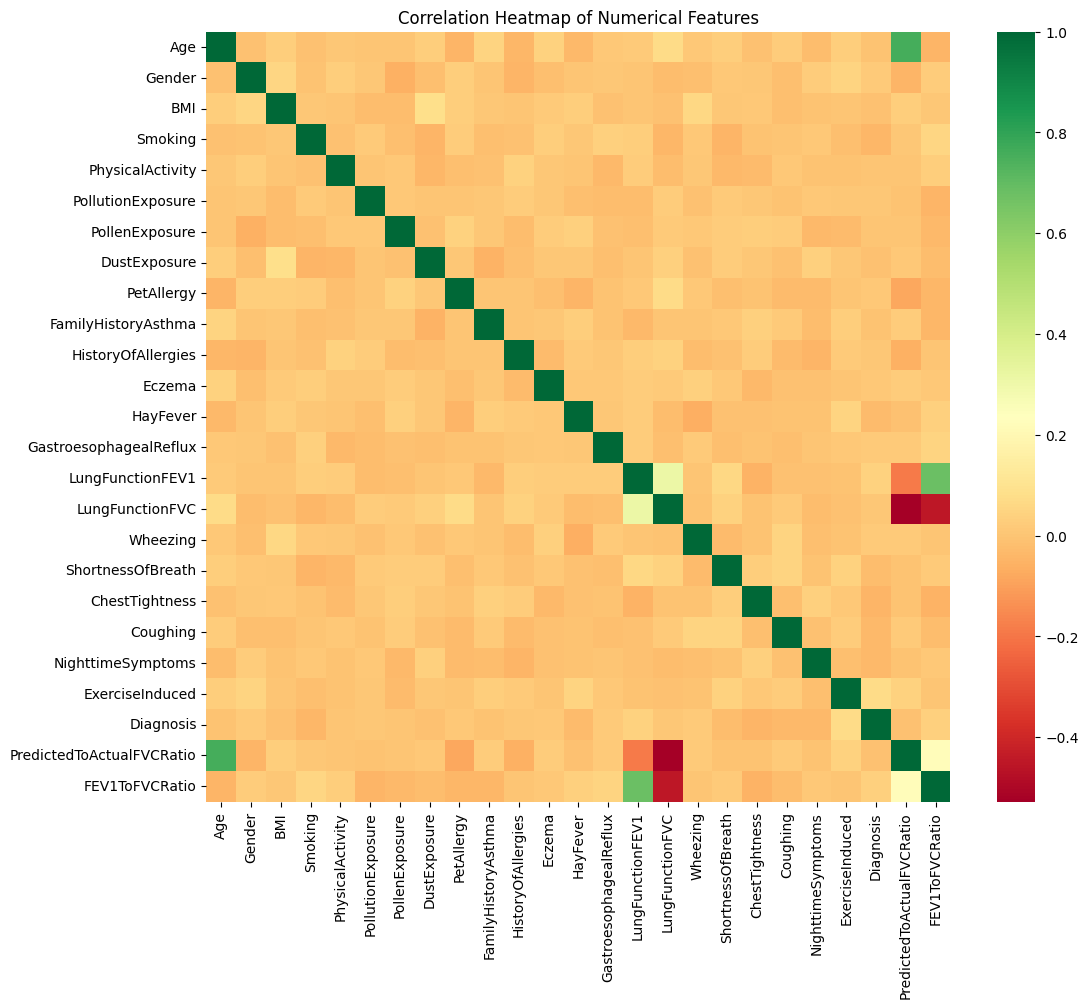

In [17]:
numerical_features = df.select_dtypes(exclude='object').columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_features].corr(), cmap='RdYlGn')
plt.title('Correlation Heatmap of Numerical Features')

In [18]:
print(df.columns)
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

Index(['Age', 'Gender', 'BMI', 'Smoking', 'PhysicalActivity',
       'PollutionExposure', 'PollenExposure', 'DustExposure', 'PetAllergy',
       'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema', 'HayFever',
       'GastroesophagealReflux', 'LungFunctionFEV1', 'LungFunctionFVC',
       'Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing',
       'NighttimeSymptoms', 'ExerciseInduced', 'Diagnosis',
       'PredictedToActualFVCRatio', 'FEV1ToFVCRatio'],
      dtype='object')


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
print("printing x_train, x_test, y_train, y_test respectively")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

printing x_train, x_test, y_train, y_test respectively
(1191, 24)
(397, 24)
(1191,)
(397,)


In [21]:
print(X_train.head())
print(X_test.head())


      Age  Gender        BMI  Smoking  PhysicalActivity  PollutionExposure  \
1967   50       0  27.839653        1          1.143087           9.764933   
899    34       1  21.298444        0          8.735878           6.973974   
736    23       1  30.799569        0          5.015779           0.716800   
1970   60       0  32.504546        1          8.854674           7.787955   
1547   41       1  32.915940        0          6.057978           8.076427   

      PollenExposure  DustExposure  PetAllergy  FamilyHistoryAsthma  ...  \
1967        1.219540      4.648113           0                    0  ...   
899         1.711176      6.342476           0                    0  ...   
736         4.843461      3.381023           0                    0  ...   
1970        4.772291      9.748459           0                    0  ...   
1547        7.594453      7.066936           0                    0  ...   

      LungFunctionFEV1  LungFunctionFVC  Wheezing  ShortnessOfBreath  \
19

In [23]:
# Using smote to increase accuracy
print("Shape before SMOTE: ", X_train.shape, y_train.shape)
print("Value counts before SMOTE:")
print(pd.Series(y_train).value_counts())
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Shape after SMOTE: ", X_train.shape, y_train.shape)
print("Value counts after SMOTE:")
print(pd.Series(y_train).value_counts())

# Standard scale to scale the data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train)
print(X_test)

Shape before SMOTE:  (2260, 24) (2260,)
Value counts before SMOTE:
Diagnosis
0    1130
1    1130
Name: count, dtype: int64
Shape after SMOTE:  (2260, 24) (2260,)
Value counts after SMOTE:
Diagnosis
0    1130
1    1130
Name: count, dtype: int64
[[ 0.25227022 -0.76257822  0.07890327 ... -1.09278303  1.94053542
  -0.27237338]
 [-0.5621295   1.31134089 -0.87112372 ... -1.09278303 -0.71628927
  -0.91240596]
 [-1.1220293   1.31134089  0.50879308 ...  0.91509473 -0.0389514
   1.11096143]
 ...
 [ 1.32116986 -0.76257822 -1.57275446 ... -1.09278303  1.91372805
   1.32694428]
 [-0.2567296  -0.76257822  0.5230509  ... -1.09278303 -0.78185073
  -1.42048436]
 [-1.07112932 -0.76257822  0.57638129 ...  0.91509473 -0.73953021
   0.7490364 ]]
[[-0.10402965  1.31134089  0.10186448 ...  0.91509473  3.15832411
   1.35379335]
 [ 0.20137024  1.31134089  0.94254725 ...  0.91509473 -0.48121499
   1.05044171]
 [-0.20582962  1.31134089 -0.1817093  ...  0.91509473  0.27872273
   1.72451037]
 ...
 [ 0.35407019  1.

In [24]:
def train_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted', verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    print("Best parameters found:")
    print(grid_search.best_params_)
    
    y_pred = (y_prob >= 0.3).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:')
    print(conf_matrix)
    
    class_report = classification_report(y_test, y_pred)
    print('Classification Report:')
    print(class_report)
    
    return best_model

In [25]:
#Use shap to check the graph and table of feature contribution
def analyze_shap_values(model, X_train, X_test, feature_names):
    """
    Analyzes SHAP values for a given model and dataset.

    Parameters:
    - model: Trained machine learning model.
    - X_train: Training feature data.
    - X_test: Test feature data.
    - feature_names: List of feature names.

    Returns:
    - feature_importance_df: DataFrame containing feature importance based on SHAP values.
    """
    # Use the appropriate masker
    explainer = shap.Explainer(model, masker=shap.maskers.Independent(X_train), feature_names=feature_names)
    shap_values = explainer(X_test)

    # Plot summary of SHAP values for feature importance
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)

    # Calculate mean absolute SHAP values for each feature
    mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
    
    # Ensure mean_abs_shap_values is 1D (handle multi-class case)
    if mean_abs_shap_values.ndim > 1:
        mean_abs_shap_values = mean_abs_shap_values.mean(axis=0)

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean Absolute SHAP Value': mean_abs_shap_values
    })

    # Sort the DataFrame by feature importance
    feature_importance_df = feature_importance_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)

    # Display the feature importance table
    print("Feature Importance based on SHAP Values:")
    print(feature_importance_df)

    # Optionally, plot the feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Mean Absolute SHAP Value', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title('Feature Importance based on SHAP Values')
    plt.show()

    return feature_importance_df

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found:
{'C': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
Accuracy: 0.69
Confusion Matrix:
[[268 104]
 [ 18   7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.81       372
           1       0.06      0.28      0.10        25

    accuracy                           0.69       397
   macro avg       0.50      0.50      0.46       397
weighted avg       0.88      0.69      0.77       397



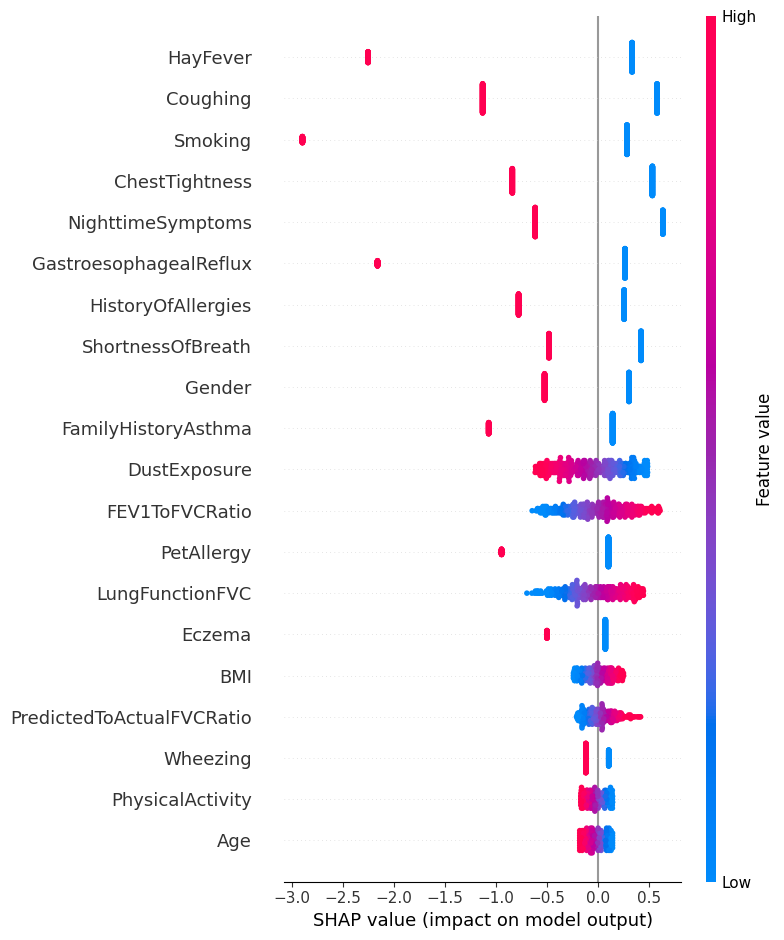

Feature Importance based on SHAP Values:
                      Feature  Mean Absolute SHAP Value
12                   HayFever                  0.857928
19                   Coughing                  0.854577
3                     Smoking                  0.746629
18             ChestTightness                  0.672755
20          NighttimeSymptoms                  0.624748
13     GastroesophagealReflux                  0.557794
10         HistoryOfAllergies                  0.475177
17          ShortnessOfBreath                  0.448916
1                      Gender                  0.408830
9         FamilyHistoryAsthma                  0.401788
7                DustExposure                  0.277004
23             FEV1ToFVCRatio                  0.260617
8                  PetAllergy                  0.235756
15            LungFunctionFVC                  0.234589
11                     Eczema                  0.161933
2                         BMI                  0.118289
22  Pre

/var/folders/58/t76sxn_93sz7kp5fv10pnltr0000gn/T/ipykernel_39625/906238163.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mean Absolute SHAP Value', y='Feature', data=feature_importance_df, palette='viridis')


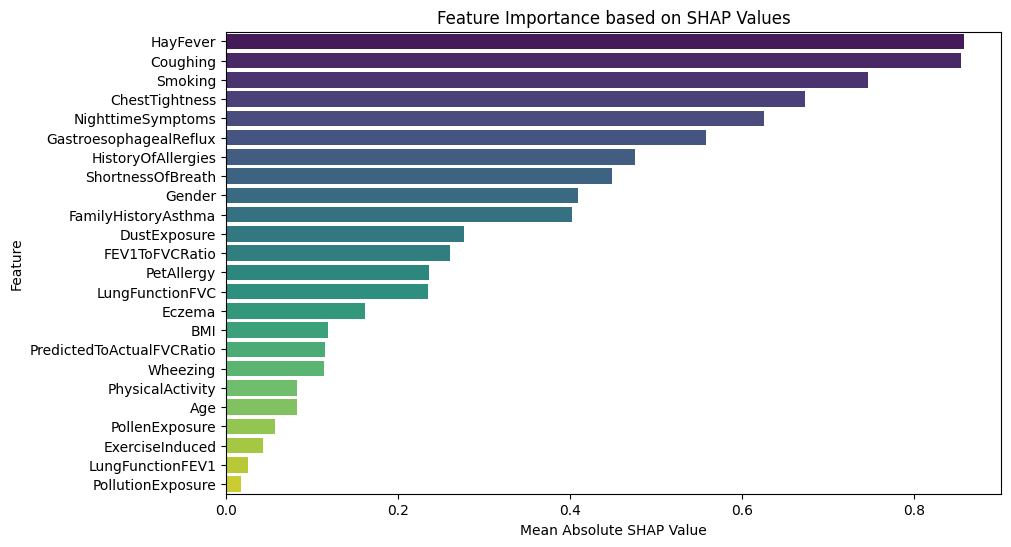

,Feature,Mean Absolute SHAP Value
12,HayFever,0.857928
19,Coughing,0.854577
3,Smoking,0.746629
18,ChestTightness,0.672755
20,NighttimeSymptoms,0.624748
13,GastroesophagealReflux,0.557794
10,HistoryOfAllergies,0.475177
17,ShortnessOfBreath,0.448916
1,Gender,0.408830
9,FamilyHistoryAsthma,0.401788


In [26]:
# Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 10}, None]
}
model_lr = LogisticRegression(max_iter=10000)
best_model = train_and_evaluate_model(model_lr, param_grid_lr, X_train, y_train, X_test, y_test)

analyze_shap_values(best_model, X_train, X_test, X.columns)

In [27]:
# Random Forest classifier
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}
model_rf = RandomForestClassifier()
best_model = train_and_evaluate_model(model_rf, param_grid_rf, X_train, y_train, X_test, y_test)

# analyze_shap_values(best_model, X_train, X_test, X.columns)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found:
{'class_weight': None, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.80
Confusion Matrix:
[[316  56]
 [ 22   3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       372
           1       0.05      0.12      0.07        25

    accuracy                           0.80       397
   macro avg       0.49      0.48      0.48       397
weighted avg       0.88      0.80      0.84       397



In [28]:
# Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}
model_gb = GradientBoostingClassifier()
best_model = train_and_evaluate_model(model_gb, param_grid_gb, X_train, y_train, X_test, y_test)

# analyze_shap_values(best_model, X_train, X_test, X.columns)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.87
Confusion Matrix:
[[346  26]
 [ 24   1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       372
           1       0.04      0.04      0.04        25

    accuracy                           0.87       397
   macro avg       0.49      0.49      0.49       397
weighted avg       0.88      0.87      0.88       397

